In [25]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, length, round, sum, when, countDistinct, regexp_replace
from pyspark.sql.types import DoubleType, NumericType, StringType
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .appName("Credit Risk") \
    .getOrCreate()

In [3]:
df = spark.read.csv("../data/loan.csv", header=True, inferSchema=True)

## Số lượng sample

In [4]:
df.count()

887379

## In ra sample đầu tiên

In [5]:
df.head()

Row(id=1077501, member_id=1296599, loan_amnt=5000.0, funded_amnt=5000.0, funded_amnt_inv=4975.0, term=' 36 months', int_rate=10.65, installment=162.87, grade='B', sub_grade='B2', emp_title=None, emp_length='10+ years', home_ownership='RENT', annual_inc='24000.0', verification_status='Verified', issue_d='Dec-2011', loan_status='Fully Paid', pymnt_plan='n', url='https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501', desc='  Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>', purpose='credit_card', title='Computer', zip_code='860xx', addr_state='AZ', dti='27.65', delinq_2yrs='0.0', earliest_cr_line='Jan-1985', inq_last_6mths='1.0', mths_since_last_delinq=None, mths_since_last_record=None, open_acc='3.0', pub_rec='0.0', revol_bal='13648.0', revol_util='83.7', total_acc='9.0', initial_list_status='f', out_prncp='0.0', out_prncp_inv='0.0', total_pymnt='5861.07141425', total_pymnt_inv='5831.78', total_rec_prncp='5000.0', total_rec_int='861.07', total

## Định dạng dữ liệu

In [6]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: strin

## Thống kê và làm sạch

### Các cột String nhưng có dữ liệu số

In [7]:
numeric_string_cols = [
    "annual_inc", "dti", "delinq_2yrs", "inq_last_6mths",
    "mths_since_last_delinq", "mths_since_last_record",
    "open_acc", "pub_rec", "revol_bal", "revol_util",
    "total_acc", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee",
    "last_pymnt_amnt", "collections_12_mths_ex_med",
    "mths_since_last_major_derog", "policy_code", "annual_inc_joint",
    "dti_joint", "acc_now_delinq", "tot_coll_amt", "tot_cur_bal",
    "open_acc_6m", "open_il_6m", "open_il_12m", "open_il_24m",
    "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m",
    "open_rv_24m", "max_bal_bc", "all_util", "total_rev_hi_lim",
    "inq_fi", "total_cu_tl", "inq_last_12m"
]

for c in numeric_string_cols:
    df = df.withColumn(c, col(c).cast(DoubleType()))

In [8]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: doubl

### Làm số cột dữ liệu số về 2 chữ số thập phân

In [9]:
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

for c in numeric_cols:
    df = df.withColumn(c, round(col(c), 2))

### Đếm số giá trị Null ở các cột

In [10]:
# Tạo dictionary {column: null_count}
null_count_dict = df.select([
    sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
    for c in df.columns
]).first().asDict()

# Chuyển sang DataFrame cho dễ đọc
null_count_df = spark.createDataFrame(
    [Row(column=k, null_count=v) for k, v in null_count_dict.items()]
).orderBy(col("null_count").desc())

null_count_df.show(null_count_df.count(), truncate=False)

+---------------------------+----------+
|column                     |null_count|
+---------------------------+----------+
|dti_joint                  |886771    |
|annual_inc_joint           |886749    |
|verification_status_joint  |886744    |
|il_util                    |868741    |
|mths_since_rcnt_il         |866549    |
|inq_last_12m               |866006    |
|inq_fi                     |866003    |
|max_bal_bc                 |866002    |
|all_util                   |866001    |
|total_cu_tl                |865999    |
|open_rv_12m                |865994    |
|open_rv_24m                |865990    |
|total_bal_il               |865987    |
|open_il_24m                |865978    |
|open_il_12m                |865974    |
|open_il_6m                 |865955    |
|open_acc_6m                |865932    |
|desc                       |761349    |
|mths_since_last_record     |750250    |
|mths_since_last_major_derog|665523    |
|mths_since_last_delinq     |454288    |
|next_pymnt_d   

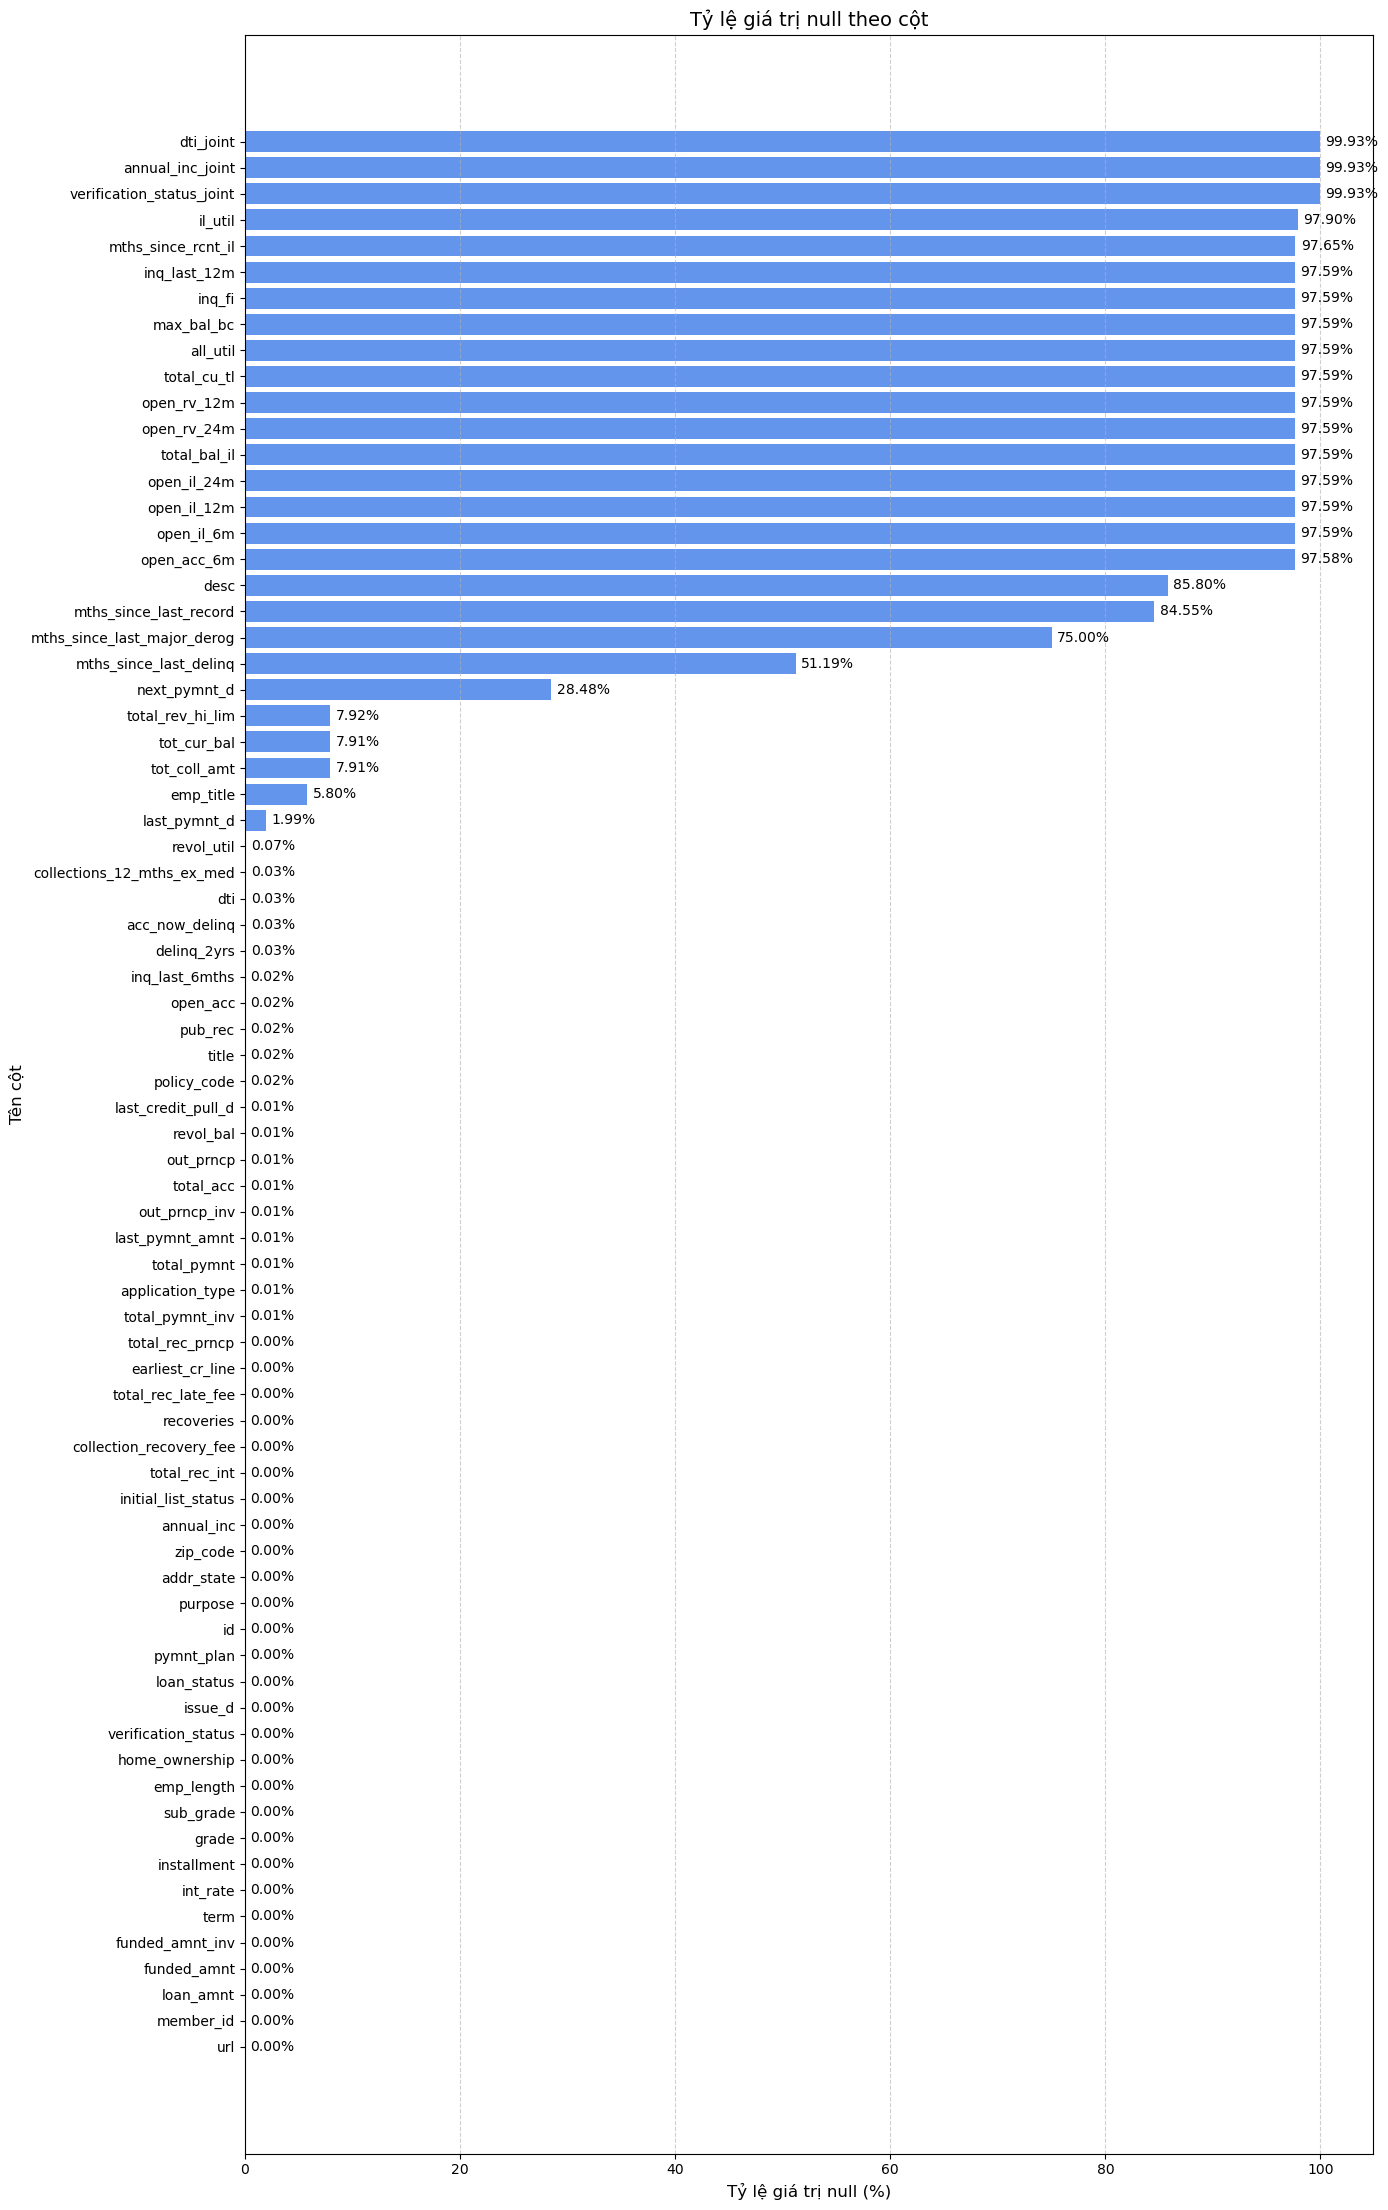

In [11]:
total_rows = df.count()

null_count_df = null_count_df.withColumn(
    "null_percent",
    (col("null_count") / total_rows * 100)
)

null_count_pd = null_count_df.toPandas()

null_count_pd = null_count_pd.sort_values(by="null_percent", ascending=False)

plt.figure(figsize=(14, max(6, len(null_count_pd) * 0.3)))
bars = plt.barh(null_count_pd["column"], null_count_pd["null_percent"], color='cornflowerblue')

plt.xlabel("Tỷ lệ giá trị null (%)", fontsize=12)
plt.ylabel("Tên cột", fontsize=12)
plt.title("Tỷ lệ giá trị null theo cột", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, 
             bar.get_y() + bar.get_height()/2,
             f"{width:.2f}%",
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Kiểm tra số hàng có giá trị null (ở các cột ít giá trị null)

In [12]:
cols_to_check = [
    "revol_util", "collections_12_mths_ex_med", "dti", "acc_now_delinq",
    "delinq_2yrs", "inq_last_6mths", "open_acc", "pub_rec", "title",
    "policy_code", "last_credit_pull_d", "revol_bal", "out_prncp",
    "total_acc", "out_prncp_inv", "last_pymnt_amnt", "total_pymnt",
    "application_type", "total_pymnt_inv", "total_rec_prncp",
    "earliest_cr_line", "total_rec_late_fee", "collection_recovery_fee",
    "recoveries", "total_rec_int", "initial_list_status",
    "annual_inc", "purpose", "zip_code", "addr_state"
]

condition = None
for c in cols_to_check:
    cond = (col(c).isNull()) | (col(c) == "")
    condition = cond if condition is None else (condition | cond)

rows_with_null = df.filter(condition).count()

print(f"Số hàng có ít nhất 1 giá trị null hoặc rỗng trong {len(cols_to_check)} cột: {rows_with_null}")

Số hàng có ít nhất 1 giá trị null hoặc rỗng trong 30 cột: 1070


### Do số lượng ít nên sẽ loại bỏ các hàng ở trên

In [13]:
condition = None
for c in cols_to_check:
    if isinstance(df.schema[c].dataType, StringType):
        cond = (col(c).isNull()) | (col(c) == "")
    else:
        cond = col(c).isNull()
    condition = cond if condition is None else (condition | cond)
    
print(f"Số hàng ban đầu: {df.count()}")

df_clean = df.filter(~condition)

print(f"Số hàng sau khi xóa: {df_clean.count()}")
print(f"Đã xóa {df.count() - df_clean.count()} hàng chứa null hoặc rỗng.")
df = df_clean

Số hàng ban đầu: 887379
Số hàng sau khi xóa: 886309
Đã xóa 1070 hàng chứa null hoặc rỗng.


### Số lượng giá trị unique ở mỗi cột

In [14]:
unique_counts = []
for c in df.columns:
    n_unique = df.select(countDistinct(col(c)).alias("unique_count")).collect()[0]["unique_count"]
    unique_counts.append(Row(column=c, unique_count=n_unique))

unique_df = spark.createDataFrame(unique_counts).orderBy(col("unique_count").desc())
unique_df.show(truncate=False)

+----------------+------------+
|column          |unique_count|
+----------------+------------+
|url             |886309      |
|id              |886309      |
|member_id       |886309      |
|total_pymnt_inv |506059      |
|total_pymnt     |492739      |
|tot_cur_bal     |327196      |
|total_rec_int   |324416      |
|emp_title       |298869      |
|out_prncp_inv   |266122      |
|total_rec_prncp |260065      |
|out_prncp       |248224      |
|last_pymnt_amnt |232158      |
|desc            |123977      |
|revol_bal       |73697       |
|installment     |68638       |
|title           |62803       |
|annual_inc      |49337       |
|recoveries      |22975       |
|total_rev_hi_lim|21246       |
|total_bal_il    |16935       |
+----------------+------------+
only showing top 20 rows



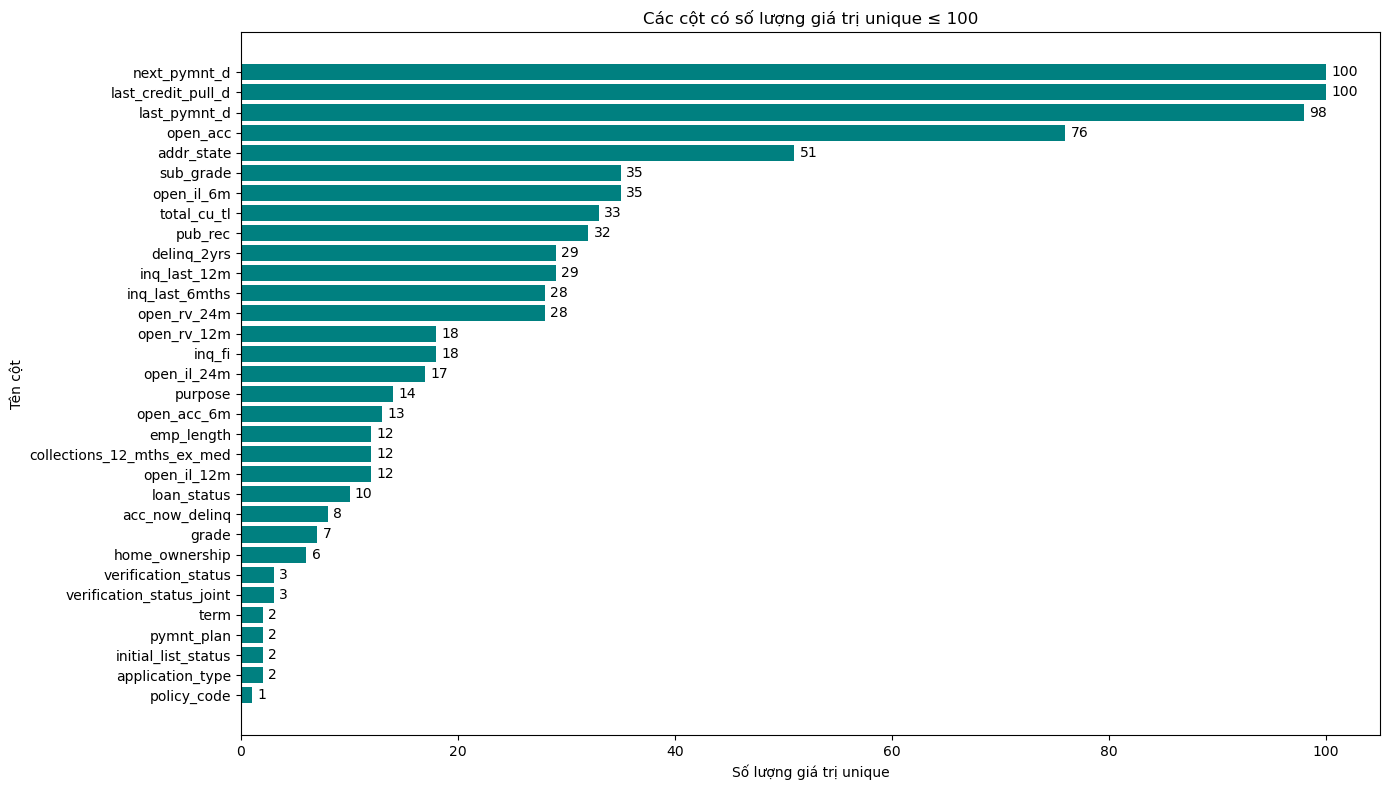

In [15]:
threshold = 100
filtered_df = unique_df.filter(col("unique_count") <= threshold)
unique_pd = filtered_df.orderBy(col("unique_count").desc()).toPandas()

plt.figure(figsize=(14, 8))
bars = plt.barh(unique_pd["column"], unique_pd["unique_count"], color="teal")

plt.xlabel("Số lượng giá trị unique")
plt.ylabel("Tên cột")
plt.title(f"Các cột có số lượng giá trị unique ≤ {threshold}")
plt.gca().invert_yaxis()

# 🔢 Thêm nhãn số lên thanh
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5,
             bar.get_y() + bar.get_height()/2,
             f"{int(width)}",
             va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Điền giá trị 0 (kiểu double) thay cho null đối với các cột
| **Cột**              | **Ý nghĩa**                                                                      |
| -------------------- | -------------------------------------------------------------------------------- |
| `tot_coll_amt`       | Tổng số tiền thu hồi (collections) của người vay.                                |
| `tot_cur_bal`        | Tổng dư nợ hiện tại trên tất cả các tài khoản.                                   |
| `open_acc_6m`        | Số tài khoản tín dụng được mở trong 6 tháng gần nhất.                            |
| `open_il_6m`         | Số khoản vay trả góp (installment loans) mở trong 6 tháng gần nhất.              |
| `open_il_12m`        | Số khoản vay trả góp mở trong 12 tháng gần nhất.                                 |
| `open_il_24m`        | Số khoản vay trả góp mở trong 24 tháng gần nhất.                                 |
| `mths_since_rcnt_il` | Số tháng kể từ khi mở khoản vay trả góp gần nhất.                                |
| `total_bal_il`       | Tổng dư nợ của tất cả các khoản vay trả góp.                                     |
| `il_util`            | Tỷ lệ sử dụng khoản vay trả góp (installment utilization).                       |
| `open_rv_12m`        | Số tài khoản tín dụng quay vòng (revolving accounts) mở trong 12 tháng gần nhất. |
| `open_rv_24m`        | Số tài khoản quay vòng mở trong 24 tháng gần nhất.                               |
| `max_bal_bc`         | Dư nợ cao nhất từng đạt được trên các tài khoản thẻ tín dụng (bankcard).         |
| `all_util`           | Tỷ lệ sử dụng tín dụng tổng hợp (tổng dư nợ / tổng hạn mức).                     |
| `total_rev_hi_lim`   | Tổng hạn mức tín dụng quay vòng cao nhất.                                        |
| `inq_fi`             | Số lần truy vấn tín dụng từ các tổ chức tài chính (financial inquiries).         |
| `total_cu_tl`        | Tổng số tài khoản tín dụng thuộc liên hiệp tín dụng (credit union accounts).     |
| `inq_last_12m`       | Số lần bị truy vấn tín dụng trong 12 tháng gần nhất.                             |


In [16]:
cols_to_fill = [
    "tot_coll_amt", "tot_cur_bal",
    "open_acc_6m", "open_il_6m", "open_il_12m", "open_il_24m",
    "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m",
    "open_rv_24m", "max_bal_bc", "all_util", "total_rev_hi_lim",
    "inq_fi", "total_cu_tl", "inq_last_12m"
]

for c in cols_to_fill:
    df = df.withColumn(
        c,
        when(col(c).isNull() | (col(c) == ""), 0.0)
        .otherwise(col(c).cast("double"))
        .cast("double")
    )

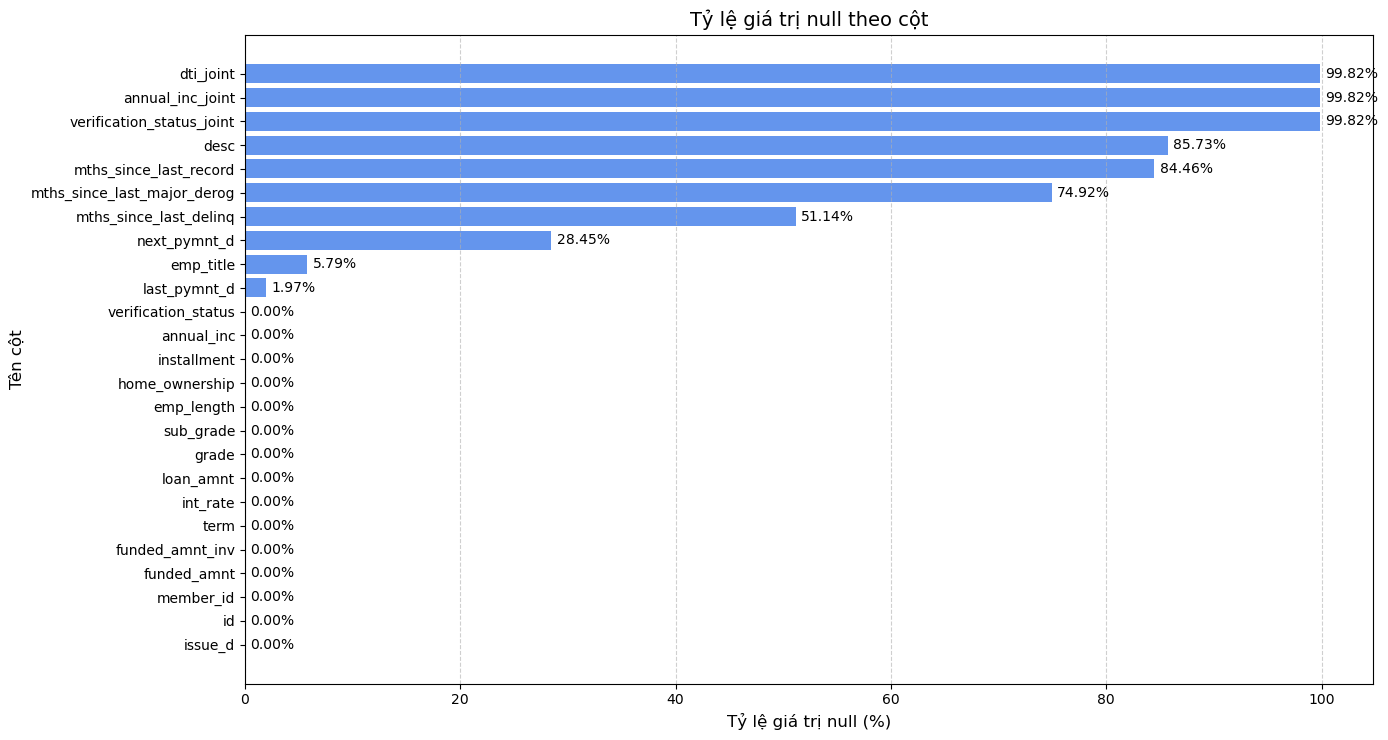

In [17]:
null_count_dict = df.select([
    sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
    for c in df.columns
]).first().asDict()

null_count_df = spark.createDataFrame(
    [Row(column=k, null_count=v) for k, v in null_count_dict.items()]
).orderBy(col("null_count").desc())
null_count_df = null_count_df.withColumn(
    "null_percent",
    (col("null_count") / total_rows * 100)
)

null_count_pd = null_count_df.toPandas().head(25)

null_count_pd = null_count_pd.sort_values(by="null_percent", ascending=False)

plt.figure(figsize=(14, max(6, len(null_count_pd) * 0.3)))
bars = plt.barh(null_count_pd["column"], null_count_pd["null_percent"], color='cornflowerblue')

plt.xlabel("Tỷ lệ giá trị null (%)", fontsize=12)
plt.ylabel("Tên cột", fontsize=12)
plt.title("Tỷ lệ giá trị null theo cột", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, 
             bar.get_y() + bar.get_height()/2,
             f"{width:.2f}%",
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Với các cột dành cho người vạy kiểu JOINT:
| Cột                             | Ý nghĩa                                                                                  | Kiểu dữ liệu     | Ghi chú                                              |
| ------------------------------- | ---------------------------------------------------------------------------------------- | ---------------- | ---------------------------------------------------- |
| **`dti_joint`**                 | Debt-to-Income ratio của **cả hai người vay chung** (joint application).                 | Số thực (double) | Nếu không phải hồ sơ vay chung → có thể điền `0.0`.  |
| **`annual_inc_joint`**          | Thu nhập hàng năm **kết hợp của hai người** trong hồ sơ vay chung.                       | Số thực (double) | Nếu không phải hồ sơ vay chung → điền `0.0`.         |
| **`verification_status_joint`** | Trạng thái xác minh thu nhập cho hồ sơ vay chung (ví dụ: "Verified", "Source Verified"). | Chuỗi (string)   | Nếu không phải hồ sơ vay chung → điền `"Not joint"`. |



In [18]:
df = df.withColumn(
    "dti_joint",
    when(col("dti_joint").isNull() | (col("dti_joint") == ""), 0.0)
    .otherwise(col("dti_joint").cast("double"))
    .cast("double")
)

df = df.withColumn(
    "annual_inc_joint",
    when(col("annual_inc_joint").isNull() | (col("annual_inc_joint") == ""), 0.0)
    .otherwise(col("annual_inc_joint").cast("double"))
    .cast("double")
)

df = df.withColumn(
    "verification_status_joint",
    when(col("verification_status_joint").isNull() | (col("verification_status_joint") == ""), "Not joint")
    .otherwise(col("verification_status_joint"))
)

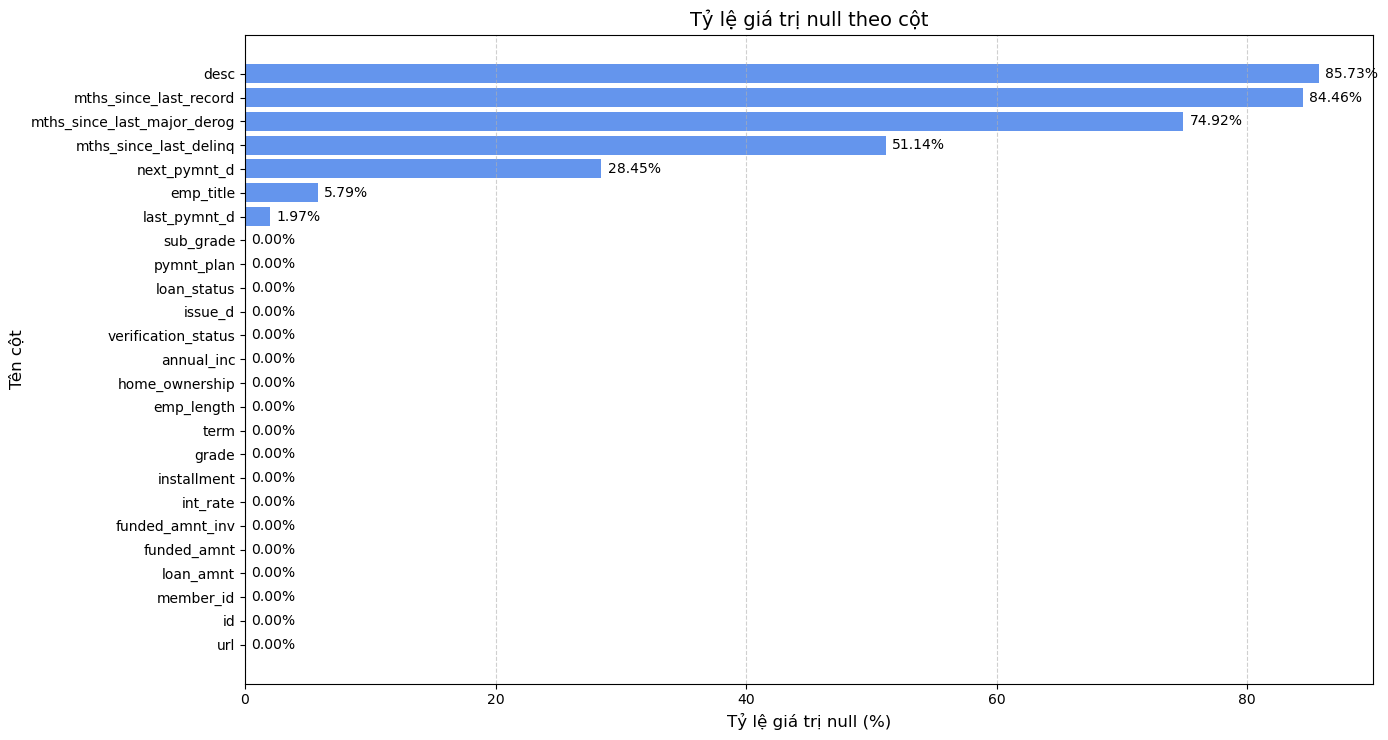

In [19]:
null_count_dict = df.select([
    sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
    for c in df.columns
]).first().asDict()

null_count_df = spark.createDataFrame(
    [Row(column=k, null_count=v) for k, v in null_count_dict.items()]
).orderBy(col("null_count").desc())
null_count_df = null_count_df.withColumn(
    "null_percent",
    (col("null_count") / total_rows * 100)
)

null_count_pd = null_count_df.toPandas().head(25)

null_count_pd = null_count_pd.sort_values(by="null_percent", ascending=False)

plt.figure(figsize=(14, max(6, len(null_count_pd) * 0.3)))
bars = plt.barh(null_count_pd["column"], null_count_pd["null_percent"], color='cornflowerblue')

plt.xlabel("Tỷ lệ giá trị null (%)", fontsize=12)
plt.ylabel("Tên cột", fontsize=12)
plt.title("Tỷ lệ giá trị null theo cột", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, 
             bar.get_y() + bar.get_height()/2,
             f"{width:.2f}%",
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Với cột desc, điền giá trị No description. Với cột emp_title, điền giá trị Unknown

In [20]:
df = df.withColumn(
    "desc",
    when(col("desc").isNull() | (col("desc") == ""), "No description")
    .otherwise(col("desc"))
)
df = df.withColumn(
    "emp_title",
    when(col("emp_title").isNull() | (col("desc") == ""), "Unknown")
    .otherwise(col("emp_title"))
)

### Với các cột mths_since_last_record, mths_since_last_major_derog, mth_since_last_delinq, điền giá trị đặc biệt -1 để đánh dấu là chưa có tháng nào
| Cột                               | Ý nghĩa                                                                                                                                                          | Tại sao có nhiều giá trị `null`                                                   | 
| --------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------- | 
| **`mths_since_last_record`**      | Số **tháng kể từ lần gần nhất có “public record”** — tức là các ghi nhận tiêu cực như phá sản, kiện tụng, thu hồi nợ được báo cáo lên cơ quan tín dụng.          | Nhiều người **chưa từng có public record**, nên trường này bị `null`.             | 
| **`mths_since_last_major_derog`** | Số **tháng kể từ lần gần nhất có “major derogatory remark”** — tức là vi phạm nghiêm trọng trong lịch sử tín dụng, ví dụ như vỡ nợ, trễ thanh toán nghiêm trọng. | Nếu người vay **chưa từng bị vi phạm nghiêm trọng**, thì trường này sẽ bị `null`. | 
| **`mths_since_last_delinq`**      | Số **tháng kể từ lần gần nhất người vay bị “delinquency”** (trễ hạn thanh toán).                                                                                 | Nếu người vay **chưa từng trễ hạn**, thì giá trị là `null`.                       | 
                                                                         


In [21]:
cols = ["mths_since_last_record", "mths_since_last_major_derog", "mths_since_last_delinq"]

for c in cols:
    df = df.withColumn(
        c,
        when(col(c).isNull(), -1).otherwise(col(c))
    )

### Với last_pymnt_d, giá trị null do Chưa có khoản thanh toán nào nên sẽ điền là No payment yet. Với cột next_pymnt_d, giá trị null do Không có thanh toán kế tiếp (vay đã xong hoặc vỡ nợ) nên sẽ điền là No future payment
| Cột                | Ý nghĩa                                                                                                                                  |
| ------------------ | ---------------------------------------------------------------------------------------------------------------------------------------- |
| **`last_pymnt_d`** | Tháng **người vay thực hiện khoản thanh toán gần nhất** (Last Payment Date) |
| **`next_pymnt_d`** | Tháng **người vay dự kiến sẽ thực hiện khoản thanh toán tiếp theo** (Next Payment Date).                                                 |


In [22]:
df = df.withColumn(
    "last_pymnt_d",
    when(col("last_pymnt_d").isNull(), "No payment yet").otherwise(col("last_pymnt_d"))
)

df = df.withColumn(
    "next_pymnt_d",
    when(col("next_pymnt_d").isNull(), "No future payment").otherwise(col("next_pymnt_d"))
)

### Kiểm tra lại số lượng null value của dataframe

In [23]:
total_nulls = df.select([
    sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
    for c in df.columns
])

expr = None
for c in total_nulls.columns:
    expr = col(c) if expr is None else expr + col(c)

total_null_count = total_nulls.select(expr.alias("total_nulls")).collect()[0]["total_nulls"]

print(f"Tổng số giá trị null hoặc rỗng trong toàn bộ DataFrame: {total_null_count}")

Tổng số giá trị null hoặc rỗng trong toàn bộ DataFrame: 0


## Xuất dữ liệu đã làm sạch

In [26]:
df = df.withColumn("desc", regexp_replace(col("desc"), "\r|\n", " "))
df.coalesce(1).write \
  .option("header", True) \
  .option("quote", "\"") \
  .option("escape", "\"") \
  .option("nullValue", "") \
  .option("emptyValue", "") \
  .mode("overwrite") \
  .csv("../data/processed_data")